<a href="https://colab.research.google.com/github/AlexeyProvorov/NeuroMind/blob/main/Latent_space_of_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

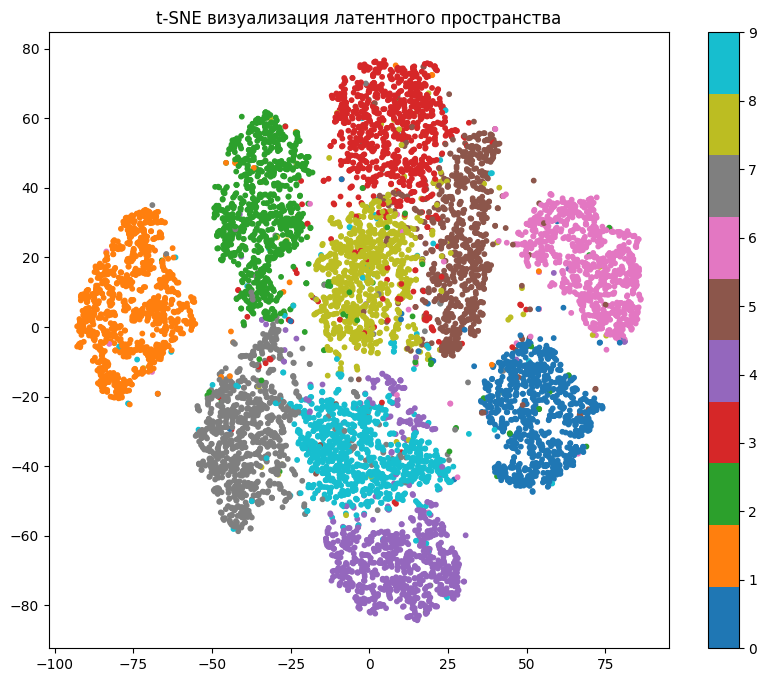

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

# Подготовка тестовых данных
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Извлечение латентных векторов для тестовых данных
vae.eval()  # Перевод модели в режим оценки
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.view(-1, input_dim)  # Преобразование изображений в вектор
        encoded = vae.encoder(images)
        mu, logvar = torch.chunk(encoded, 2, dim=-1)
        latent_vectors.append(mu)  # Сохраняем только средние значения (mu)
        labels.append(targets)

latent_vectors = torch.cat(latent_vectors).cpu().numpy()  # Преобразуем в NumPy для работы с t-SNE
labels = torch.cat(labels).cpu().numpy()

# Применение t-SNE для снижения размерности до 2D для визуализации
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter)
plt.title("t-SNE визуализация латентного пространства")
plt.show()


By ascending latent space

Epoch 1, Loss: 184.7987381347656
Epoch 2, Loss: 166.83810344238282
Epoch 3, Loss: 161.58724223632814
Epoch 4, Loss: 158.76696490071615
Epoch 5, Loss: 156.85219212239582
Epoch 6, Loss: 155.57812804361978
Epoch 7, Loss: 154.57858509928386
Epoch 8, Loss: 153.79164705403645
Epoch 9, Loss: 153.03622054036458
Epoch 10, Loss: 152.35385288085936
Epoch 11, Loss: 151.80448206380208
Epoch 12, Loss: 151.26386732584635
Epoch 13, Loss: 150.7551048828125
Epoch 14, Loss: 150.46809586588543
Epoch 15, Loss: 150.03693163248698
Epoch 16, Loss: 149.73049086914062
Epoch 17, Loss: 149.43460108235678
Epoch 18, Loss: 149.0712055908203
Epoch 19, Loss: 148.76189444173178
Epoch 20, Loss: 148.6973151204427


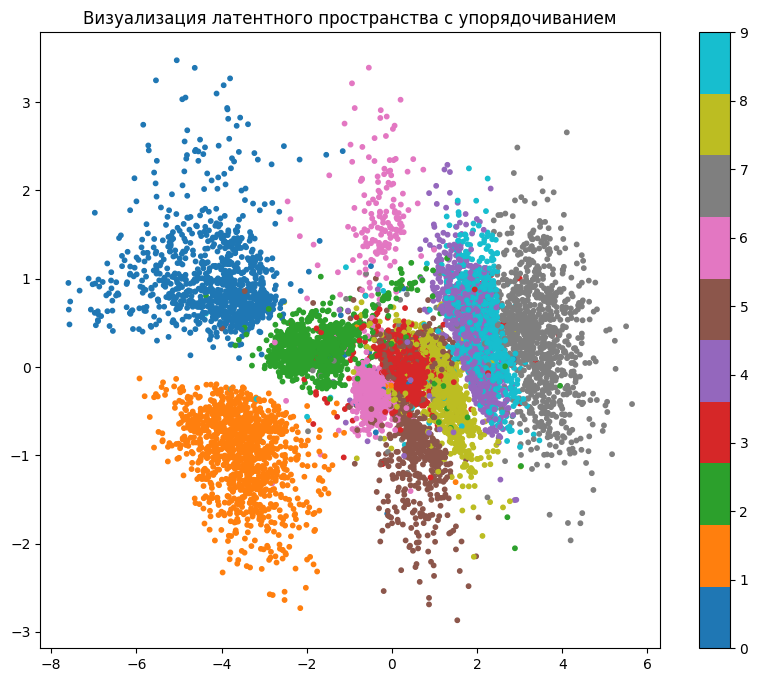

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Параметры
batch_size = 64
latent_dim = 2  # Мы можем использовать 2 измерения, чтобы легче было визуализировать
input_dim = 28 * 28  # Размерность изображения MNIST (28x28)
num_epochs = 20
learning_rate = 1e-3

# Подготовка данных
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Определение модели VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # для среднего значения и дисперсии
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Выходные значения в диапазоне [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparametrization trick

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=-1)  # Разбиение на среднее и дисперсию
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Инициализация модели и оптимизатора
vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Жесткое целевое латентное пространство: задаём для каждой цифры фиксированную позицию
target_latent_space = {
    0: torch.tensor([-9.0, 0.0]),
    1: torch.tensor([-7.0, 0.0]),
    2: torch.tensor([-5.0, 0.0]),
    3: torch.tensor([-3.0, 0.0]),
    4: torch.tensor([-1.0, 0.0]),
    5: torch.tensor([1.0, 0.0]),
    6: torch.tensor([3.0, 0.0]),
    7: torch.tensor([5.0, 0.0]),
    8: torch.tensor([7.0, 0.0]),
    9: torch.tensor([9.0, 0.0])
}

# Функция потерь с учетом фиксированных позиций латентного пространства и равных расстояний
def loss_function(reconstructed, x, mu, logvar, labels):
    # Основные составляющие VAE потерь
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Приведение латентных векторов к целевым позициям
    latent_order_loss = 0
    for i in range(len(labels)):
        target = target_latent_space[int(labels[i].item())].to(mu.device)  # Получаем целевой вектор
        latent_order_loss += torch.mean((mu[i] - target).pow(2))  # Регрессия к целевой позиции

    # Регуляризация для равномерного расстояния между последовательными цифрами
    sorted_labels, indices = torch.sort(labels)
    sorted_mu = mu[indices]
    distance_loss = 0
    for i in range(1, len(sorted_mu)):
        distance_loss += torch.mean((sorted_mu[i] - sorted_mu[i-1]).pow(2))

    return reconstruction_loss + kl_divergence + latent_order_loss + distance_loss * 0.1  # Уравновешивание влияния

# Обучение модели
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.view(-1, input_dim)

        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(images)

        loss = loss_function(reconstructed, images, mu, logvar, labels)  # Функция потерь с фиксированием позиций
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset)}')

# Визуализация латентного пространства с использованием t-SNE (в 2D это необязательно, но оставим)
vae.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.view(-1, input_dim)
        encoded = vae.encoder(images)
        mu, logvar = torch.chunk(encoded, 2, dim=-1)
        latent_vectors.append(mu)  # Сохраняем среднее значение
        labels.append(targets)

latent_vectors = torch.cat(latent_vectors).cpu().numpy()  # Преобразуем в NumPy
labels = torch.cat(labels).cpu().numpy()

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter)
plt.title("Визуализация латентного пространства с упорядочиванием")
plt.show()
